In [6]:
import pandas as pd

df = pd.read_excel(r"G:\My Drive\masterDataScience\ModelEngineering\use_case_1\PSP_Jan_Feb_2019.xlsx")

In [7]:
from datetime import timedelta

def count_previous_attempts(row, minutes_window=5):
    same_amount = df['amount'] == row['amount']
    same_country = df['country'] == row['country']
    time_window = (df['tmsp'] >= (row['tmsp'] - timedelta(minutes=minutes_window))) & (df['tmsp'] < row['tmsp'])
    return df[same_amount & same_country & time_window].shape[0]

df["hour_of_day"] = df["tmsp"].dt.hour
df["day_of_week"] = df["tmsp"].dt.dayofweek
# holiday --> to little
df['previous_attempts'] = df.apply(count_previous_attempts, axis=1)


num_cols = ["amount"]
cat_cols = ["country", "PSP", '3D_secured', "card", "hour_of_day", "day_of_week"]
df.keys()

list_features = num_cols + cat_cols

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler

# https://scikit-learn.org/1.0/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions

col_trans = ColumnTransformer([
    ('num', MinMaxScaler(), num_cols),
    ('cat', OneHotEncoder(drop='if_binary'), cat_cols)
])

df_transformed = col_trans.fit_transform(df[list_features])
X = df_transformed[:, :]
y = df["success"]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

# oversampling is important, check difference!!
# Apply oversampling to the training set
oversampler = RandomOverSampler(random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)


# See the inital model performance
clf = RandomForestClassifier(random_state=10)
print('Acc:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean())
print('F1:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='f1').mean())
print('ROC AUC:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='roc_auc').mean())

params = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

Acc: 0.8795642034782094
F1: 0.8886967496282361
ROC AUC: 0.9443234250472716


In [9]:
# train network
clf = RandomForestClassifier(n_estimators=50,
                             max_depth=None,
                             min_samples_split=2,
                             min_samples_leaf=1,
                             random_state=11)
clf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=50, random_state=11)

In [10]:
# get the feature importance
feat_names_num = list(col_trans.transformers_[0][1].get_feature_names_out())
feat_names_cat = list(col_trans.transformers_[1][1].get_feature_names_out())
feature_names = feat_names_num + feat_names_cat
df_importance = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})
df_importance.sort_values('importance', ascending=False)

,feature,importance
0,amount,0.474557
8,3D_secured_1,0.027499
2,country_Germany,0.022835
3,country_Switzerland,0.019052
4,PSP_Goldcard,0.018882
1,country_Austria,0.018799
38,day_of_week_2,0.016939
36,day_of_week_0,0.015984
39,day_of_week_3,0.015902
40,day_of_week_4,0.015784


In [11]:
import pickle
# save
try:
    df = df.reset_index()
except:
    pass
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('transformer', col_trans),('classifier', clf)])
j_berka = {}
j_berka["network"] = pipeline
j_berka["df"] = df
j_berka["num_cols"] = num_cols
j_berka["cat_cols"] = cat_cols

with open('berka.pickle', 'wb') as f:
    pickle.dump(j_berka, f)


Train Acc (Original): 0.9676645216340172
Train F1 (Original): 0.968461205028175
Train ROC AUC (Original): 0.995313702845219
Train Acc (Random Guessing): 0.495911401855868
Train F1 (Random Guessing): 0.4951845192530219
Train ROC AUC (Random Guessing): 0.5
Test Acc (Original): 0.70647358328374
Test F1 (Original): 0.2605363984674329
Test ROC AUC (Original): 0.6048044274476447
Test Acc (Random Guessing): 0.5063810090590491
Test F1 (Random Guessing): 0.296617356072741
Test ROC AUC (Random Guessing): 0.5
Confusion Matrix (Original) - Train:
Confusion Matrix (Original) - Test:
Confusion Matrix (Random Guessing) - Train:
Confusion Matrix (Random Guessing) - Test:


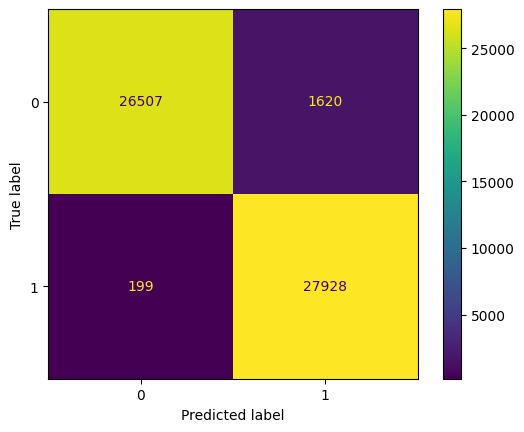

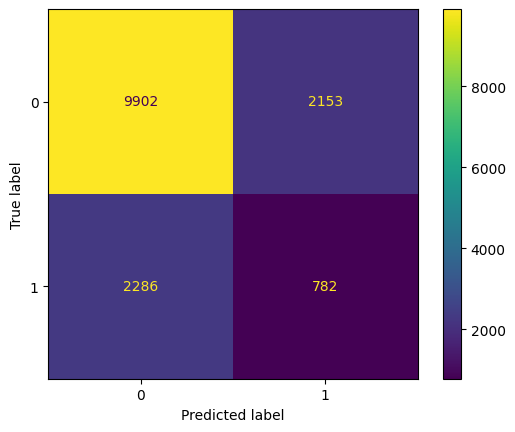

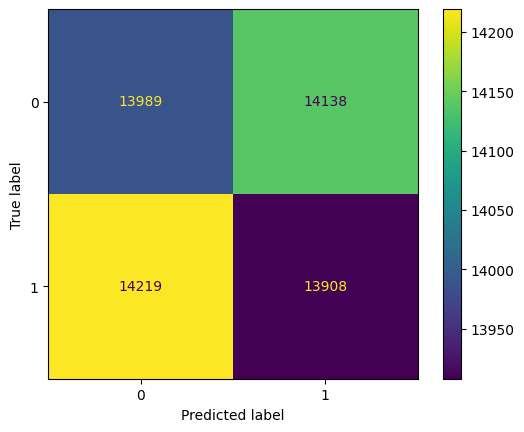

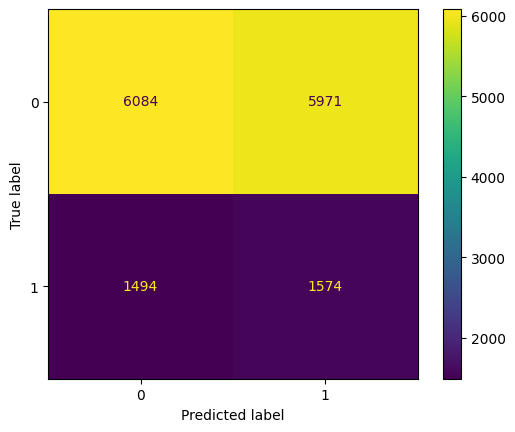

In [17]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier

# Assuming you have your data and classifier set up as before

# Create a random classifier that makes random guesses
random_classifier = DummyClassifier(strategy="uniform", random_state=42)  # "uniform" strategy for random guessing

# Fit the random classifier on the training data
random_classifier.fit(X_train, y_train)

# Predictions and probabilities from your original classifier
y_train_pred = clf.predict(X_train)
y_train_proba = clf.predict_proba(X_train)
y_test_pred = clf.predict(X_test)
y_test_proba = clf.predict_proba(X_test)

# Predictions from the random classifier
y_random_train_pred = random_classifier.predict(X_train)
y_random_test_pred = random_classifier.predict(X_test)

# Calculate and compare performance metrics
print("Train Acc (Original):", accuracy_score(y_train, y_train_pred))
print("Train F1 (Original):", f1_score(y_train, y_train_pred))
print("Train ROC AUC (Original):", roc_auc_score(y_train, y_train_proba[:, 1]))

print("Train Acc (Random Guessing):", accuracy_score(y_train, y_random_train_pred))
print("Train F1 (Random Guessing):", f1_score(y_train, y_random_train_pred))
print("Train ROC AUC (Random Guessing):", roc_auc_score(y_train, random_classifier.predict_proba(X_train)[:, 1]))

# Similar comparisons for test data
print("Test Acc (Original):", accuracy_score(y_test, y_test_pred))
print("Test F1 (Original):", f1_score(y_test, y_test_pred))
print("Test ROC AUC (Original):", roc_auc_score(y_test, y_test_proba[:, 1]))

print("Test Acc (Random Guessing):", accuracy_score(y_test, y_random_test_pred))
print("Test F1 (Random Guessing):", f1_score(y_test, y_random_test_pred))
print("Test ROC AUC (Random Guessing):", roc_auc_score(y_test, random_classifier.predict_proba(X_test)[:, 1]))

# Confusion matrices for both classifiers (original and random)
print("Confusion Matrix (Original) - Train:")
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train)
print("Confusion Matrix (Original) - Test:")
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

print("Confusion Matrix (Random Guessing) - Train:")
ConfusionMatrixDisplay.from_estimator(random_classifier, X_train, y_train)
print("Confusion Matrix (Random Guessing) - Test:")
ConfusionMatrixDisplay.from_estimator(random_classifier, X_test, y_test)


In [16]:
print(len(y_train[y_train==0]))
print(len(y_train[y_train==1]))

28127
28127
